In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from scipy.stats import binom

In [15]:
class InfectiousDiseaseModel:
    def __init__(self, population_size, num_states, num_actions, num_transitions, cf_a1, cf_a2, cq_a1, cq_a2, r, lambda_, weights):
        self.population_size = population_size
        self.num_states = num_states
        self.num_actions = num_actions
        self.num_transitions = num_transitions
        self.cf_a1 = cf_a1
        self.cf_a2 = cf_a2
        self.cq_a1 = cq_a1
        self.cq_a2 = cq_a2
        self.r = r
        self.lambda_ = lambda_
        self.weights = weights

    def a2ij(self, a):
        return a % 5, a // 5

    def ch(self, state):
        return (self.population_size - state)**1.1

    def g(self, state, action):
        a1, a2 = self.a2ij(action)
        cf = self.cf_a1[a1] + self.cf_a2[a2]
        cq = self.cq_a1[a1] * self.cq_a2[a2]
        return self.weights[0] * cf - self.weights[1] * cq + self.weights[2] * self.ch(state)

    def q(self, state, action):
        a1, a2 = self.a2ij(action)
        beta = 1.0 - 1.0 * state / self.population_size
        return 1 - np.exp(-beta * self.r[a1] * self.lambda_[a2])

    def generate_stage_costs(self):
        self.stage_cost_matrix = np.zeros((self.num_states, self.num_actions))
        for state in range(self.num_states):
            for action in range(self.num_actions):
                self.stage_cost_matrix[state, action] = self.g(state, action)

    def generate_transition_probabilities(self):
        self.transition_probability_tensor = np.zeros((self.num_actions, self.num_states, self.num_states))
        for state in range(self.num_states):
            for action in range(self.num_actions):
                if state == self.population_size:
                    self.transition_probability_tensor[action, state, self.population_size] = 1.0
                    continue
                q_prob = self.q(state, action)
                ev = state * q_prob
                start = int(max(0, ev - self.num_transitions//2))
                end = int(min(state, ev + self.num_transitions//2))
                binom_values = binom.pmf(np.arange(start, end+1), state, q_prob)
                sum_binom = np.sum(binom_values)
                for i in range(start, end+1):
                    next_state = self.population_size - i
                    prob = binom_values[i-start] / sum_binom
                    self.transition_probability_tensor[action, state, next_state] = prob

    def visualize_transition_probabilities(self):
        fig, axs = plt.subplots(4, 5, figsize=(20, 16))
        for action in range(self.num_actions):
            i, j = self.a2ij(action)
            ax = axs[j, i]
            im = ax.imshow(self.transition_probability_tensor[action, :, :], cmap='hot_r', interpolation='nearest')
            ax.set_title(f'Action Index: ({i}, {j}) = {action}')

        fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)

        plt.show()


    def visualize_stage_costs(self):
        fig, ax = plt.subplots(figsize=(2, 8))
        im = ax.imshow(self.stage_cost_matrix, cmap='hot_r', interpolation='nearest', aspect='auto')
        ax.set_title("Cost Function Matrix")
        fig.colorbar(im, ax=ax, shrink=0.6)
        plt.show()


In [16]:
# user defined parameters
populationSize = 1000
hygiene_cost = [0, 1, 5, 6, 9]
socialdistancing_cost = [0, 1, 10, 30]
hygiene_quality = [1, 0.7, 0.5, 0.4, 0.05]
socialdistancing_quality = [1, 0.9, 0.5, 0.1]
numTransitions = 100
weight_cost = 20
weight_quality = 25
weight_health = 0.5

hygiene_effectiveness = [0.25, 0.125, 0.08, 0.05, 0.03]
socialdistancing_effectiveness = [200, 160, 100, 10]


# derived parameters
num_states = populationSize + 1
num_actions = len(hygiene_cost) * len(socialdistancing_cost)



idm = InfectiousDiseaseModel(populationSize, num_states, num_actions, numTransitions, hygiene_cost, socialdistancing_cost, hygiene_quality, socialdistancing_quality, hygiene_effectiveness, socialdistancing_effectiveness, [weight_cost, weight_quality, weight_health])


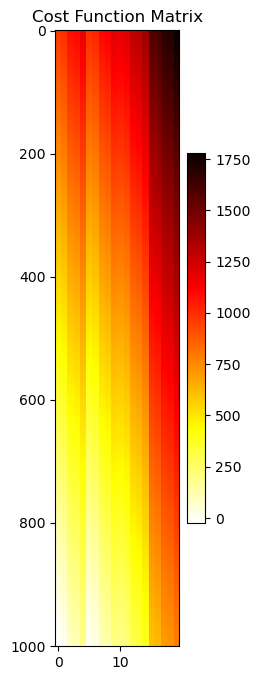

In [17]:
idm.generate_stage_costs()
idm.visualize_stage_costs()



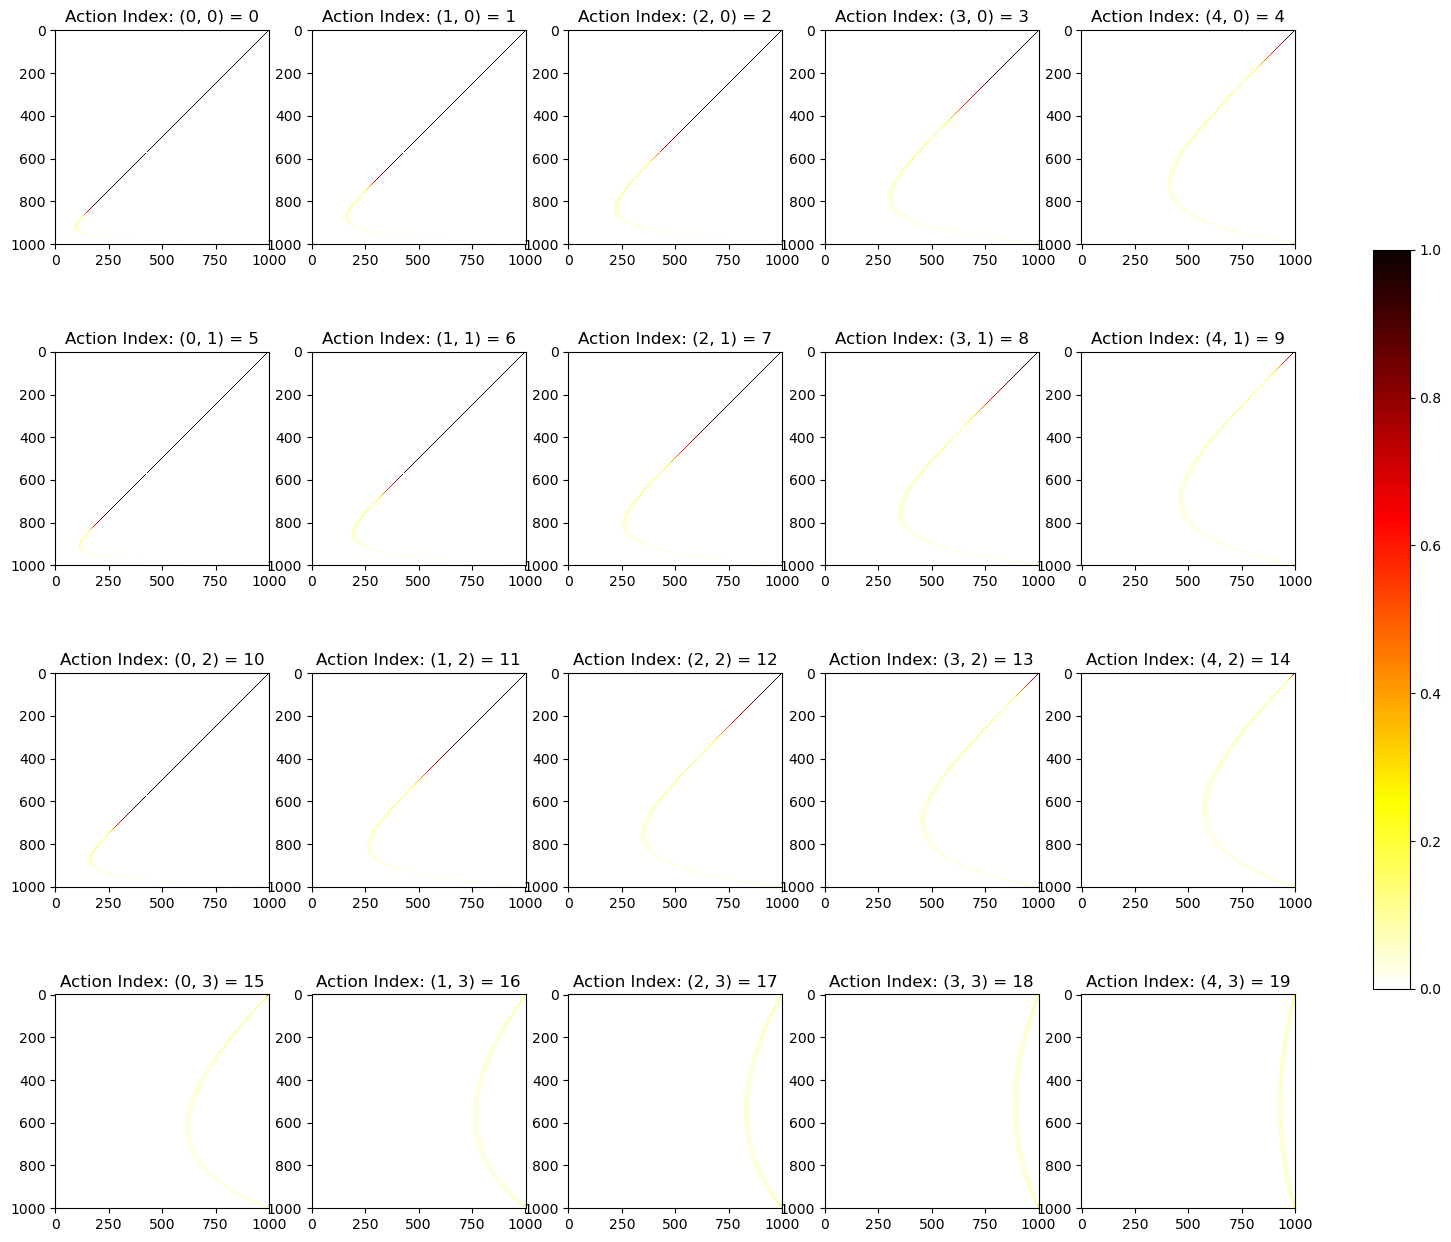

In [18]:
idm.generate_transition_probabilities()
idm.visualize_transition_probabilities()

